# Kurtosis of eddy PV field

In [1]:
import h5py
import numpy as np
from numpy.fft import irfft2
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import SymmetricalLogLocator, NullFormatter
from matplotlib.gridspec import GridSpec
import cmocean as cmo
import seaborn as sns
sns.set_style('darkgrid')
import warnings

In [3]:
def addTicks(ax,base,linthresh):
    ax.xaxis.set_major_locator(SymmetricalLogLocator(base=base, linthresh=linthresh))
    subs = np.arange(2, 10) * 0.1
    ax.xaxis.set_minor_locator(SymmetricalLogLocator(base=base, subs=subs, linthresh=linthresh))
    ax.xaxis.set_minor_formatter(NullFormatter())

    # Filter out ticks inside the linear region
    major_ticks = [t for t in ax.get_xticks() if abs(t) >= linthresh]
    minor_ticks = [t for t in ax.get_xticks(minor=True) if abs(t) >= linthresh]

    major_ticks.extend([-linthresh, linthresh])
    major_ticks = sorted(set(major_ticks))  # remove duplicates and sort

    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.tick_params(which="both", bottom=True)

In [4]:
def load_kurtosis(slope,layer,field,fieldtype,days=100):
    if field=='all': # average over all fields
        fname = '../../Results/Results_GeophysicalFlows/SmallLd/qpsi/simulation_s'+slope+'_field1_kurtosis_'+fieldtype+layer+'.csv'
        kurt_1 = pd.read_csv(fname)
        fname = '../../Results/Results_GeophysicalFlows/SmallLd/qpsi/simulation_s'+slope+'_field2_kurtosis_'+fieldtype+layer+'.csv'
        kurt_2 = pd.read_csv(fname)
        fname = '../../Results/Results_GeophysicalFlows/SmallLd/qpsi/simulation_s'+slope+'_field3_kurtosis_'+fieldtype+layer+'.csv'
        kurt_3 = pd.read_csv(fname)
        kurt = pd.concat([kurt_1,kurt_2,kurt_3],axis=1)
    else: # consider only one field
        fname = '../../Results/Results_GeophysicalFlows/SmallLd/qpsi/simulation_s'+slope+'_field'+field+'_kurtosis_'+fieldtype+layer+'.csv'
        kurt = pd.read_csv(fname)
    kurt = np.sqrt(kurt)
    limkurt = np.nanmean(kurt[int(-days*2):]) # average over last XX days
    limstd = np.nanstd(kurt[int(-days*2):]) # standard deviation over last XX days
    return limkurt, limstd

In [ ]:
slopes = ['-7e-3','-5e-3','-3e-3','-2e-3','-1e-3','-7e-4','-5e-4','-3e-4','-2e-4','-1e-4',
            '0','1e-4','2e-4','3e-4','5e-4','7e-4','1e-3','2e-3','3e-3','5e-3','7e-3']
slopes_float = [float(s) for s in slopes]

kurt_q1 = []
kurt_std_q1 = []
kurt_q2 = []
kurt_std_q2 = []
kurt_psi1 = []
kurt_std_psi1 = []
kurt_psi2 = []
kurt_std_psi2 = []
field = 'all'
with warnings.catch_warnings(): # this will suppress all warnings in this block
    warnings.simplefilter("ignore")
    for slope in slopes:
        kurt_val1, std_val1 = load_kurtosis(slope,'1',field,'q')
        kurt_q1.append(kurt_val1)
        kurt_std_q1.append(std_val1)
        kurt_val2, std_val2 = load_kurtosis(slope,'2',field,'q')
        kurt_q2.append(kurt_val2)
        kurt_std_q2.append(std_val2)
        kurt_val1, std_val1 = load_kurtosis(slope,'1',field,'psi')
        kurt_psi1.append(kurt_val1)
        kurt_std_psi1.append(std_val1)
        kurt_val2, std_val2 = load_kurtosis(slope,'2',field,'psi')
        kurt_psi2.append(kurt_val2)
        kurt_std_psi2.append(std_val2)

In [ ]:
#%% Conversion functions
def get_qhi(qhi):
    sh = qhi.shape
    qhiZ = np.empty(sh, dtype=np.complex64)
    for i in range(sh[0]):
        for j in range(sh[1]):
            for k in range(sh[2]):
                zijk = qhi[i, j, k]
                qhiZ[i, j, k] = zijk[0] + 1j*zijk[1]

    return qhiZ

#%% Compute q and psi fields
def compute_q(slope,field):
    f = h5py.File("../../Results/Results_GeophysicalFlows/SmallLd/simulation_s"+slope+"_strongmu_field"+field+"_equilibrium.jld2", "r")

    # Grid
    grd = f["grid"]
    Lx, Ly, nx, ny, x, y = map(np.array, (grd["Lx"], grd["Ly"], grd["nx"], grd["ny"], grd["x"], grd["y"]))
    Lx, Ly, nx, ny = Lx.flatten()[0], Ly.flatten()[0], nx.flatten()[0], ny.flatten()[0]

    # Wavenumbers
    nl = ny
    nkr = nx//2 + 1
    dk = 1/(Lx/nx)
    kr = np.arange(0, nkr)*2*np.pi/Lx
    l = np.concatenate((kr[:-1], -np.flipud(kr)[:-1]))
    kr = np.reshape(kr, (1, nkr))
    l = np.reshape(l, (nl, 1))
    Krsq = kr**2 + l**2
    invKrsq = 1 / Krsq
    invKrsq[0, 0] = 0

    # Other factors needed
    f0 = np.array(f["params"]["f₀"]).flatten()[0]
    gp = np.array(f["params"]["g′"]).flatten()[0][0]
    H = np.array(f["params"]["H"])
    H1 = H['1'].flatten()[0]
    H2 = H['2'].flatten()[0]

    f0sqongp = f0**2 / gp
    F1 = f0sqongp/H1
    Delta = Krsq + f0sqongp * (H1 + H2) / (H1 * H2)
    invKrsqonDelta = invKrsq / Delta

    # Time
    t = np.array([float(ti) for ti in f["snapshots"]["t"].keys()])
    idxs = t.argsort()
    t = t[idxs]

    # Read in qh, u, v data
    qh = np.array(f["snapshots"]["qh"][str(int(t[-1]))][:]) 
    qhi = get_qhi(qh)
    q = irfft2(qhi, axes=(-2, -1))

    return q[0,:,:], q[1,:,:] # upper + lower layer last time snapshots


#%% Compute kurtosis
q1_weak, q2_weak = compute_q('-5e-4', '2')
q1_strong, q2_strong = compute_q('-5e-3', '2')

/tmp/ipykernel_690499/1645034794.py:31: RuntimeWarning: divide by zero encountered in divide
  invKrsq = 1 / Krsq


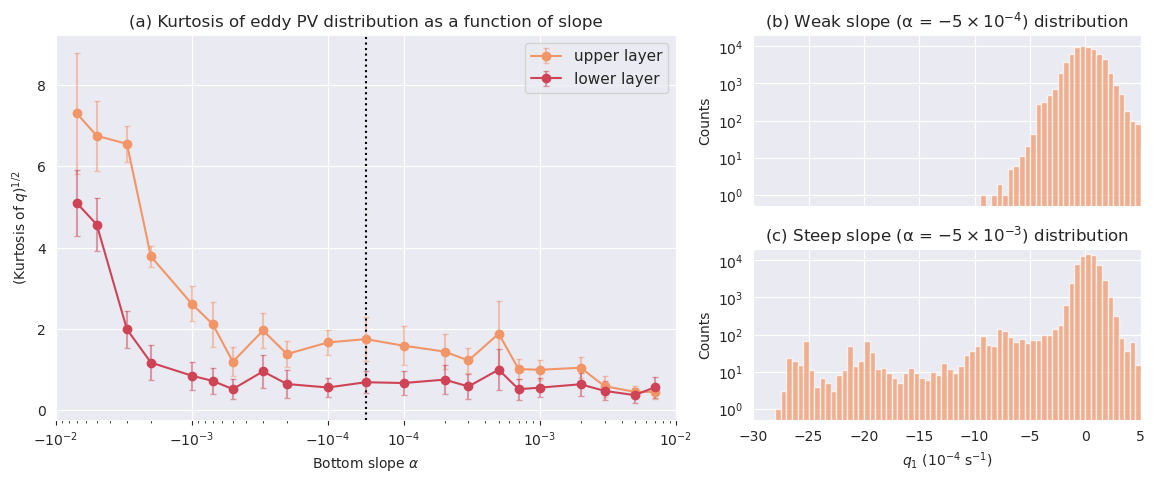

In [ ]:
cmap = matplotlib.colormaps.get_cmap('cmo.matter')
colors = cmap(np.linspace(0.25,0.5,2))

#fig, ax = plt.subplots(1,1,figsize=(7,4))
fig = plt.figure(figsize=(14,5))
gs = GridSpec(2,5,hspace=0.25,wspace=0.5)#, left=0.05, right=0.48, wspace=0.05)
ax1 = fig.add_subplot(gs[:, 0:3])
ax2 = fig.add_subplot(gs[0, 3:5])
ax3 = fig.add_subplot(gs[1, 3:5])

ax1.errorbar(slopes_float,kurt_q1,yerr=kurt_std_q1,capsize=2,marker='o',
            color=colors[0],ecolor=mcolors.to_rgba(colors[0],0.5),label=r'upper layer')
ax1.errorbar(slopes_float,kurt_q2,yerr=kurt_std_q2,capsize=2,marker='o',
            color=colors[1],ecolor=mcolors.to_rgba(colors[1],0.5),label=r'lower layer')
ax1.axvline(0,color='k',linestyle=':')
ax1.set_ylabel(r'(Kurtosis of $q$)$^{1/2}$')
ax1.set_xlabel(r'Bottom slope $\alpha$')
ax1.set_xscale('symlog', linthresh=1e-4, linscale=0.25)
addTicks(ax1,10,1e-4)
ax1.set_xlim(-1e-2, 1e-2)
ax1.legend(fontsize=11)
ax1.set_title('(a) Kurtosis of eddy PV distribution as a function of slope',fontsize=12)

cmap = matplotlib.colormaps.get_cmap('cmo.deep')
color0 = cmap(0.25)
cmap = matplotlib.colormaps.get_cmap('cmo.dense')
color1 = cmap(0.4)

ax2.hist(q1_weak.flatten()*1e4,bins=np.arange(-30,6,0.5),color=colors[0],alpha=0.7)
ax3.hist(q1_strong.flatten()*1e4,bins=np.arange(-30,6,0.5),color=colors[0],alpha=0.7)
for ax in [ax2,ax3]:
    ax.set_xlim(-30,5)
    ax.set_xticks(np.arange(-30,6,5))
    ax.set_yscale('log')
    ax.set_ylim(5e-1,2e4)
    ax.set_ylabel('Counts')
ax2.set_title(r'(b) Weak slope (α = $-5\times 10^{-4}$) distribution',fontsize=12)
ax3.set_title(r'(c) Steep slope (α = $-5\times 10^{-3}$) distribution',fontsize=12)
ax2.set_xticklabels(['']*len(ax2.get_xticks()))
ax3.set_xlabel(r'$q_1$ (10$^{-4}$ s$^{-1}$)')
#plt.savefig('../../Figures/kurtosis_q_vs_slope.pdf',bbox_inches='tight')
plt.show()